## Prepare environmental variables

Download the dataset and import the necessary packages to execute the regression models. Take a look at the file `Preprocessing.ipynb` to understand how the dataset was prepared.

In [ ]:
%pip install ucimlrepo seaborn matplotlib scikit-learn pandas numpy pygam;

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import warnings

In [35]:
from ucimlrepo import fetch_ucirepo 
 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

df_wine = pd.concat([X,y], axis=1)
 
# metadata 
print(wine_quality.metadata) 

# get variable information 
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [36]:
df_wine.drop(columns=['free_sulfur_dioxide'], inplace=True)
X.drop(columns=['free_sulfur_dioxide'], inplace=True)

## Performance evaluation of regression models

We will put here the different model evaluations

In [37]:
#Let us create first create a table to store the results of various models 
metrics =['MSE', 'MAE','R2']
regression_results = pd.DataFrame(columns=metrics)
all_plots={}

In [38]:
#Regression Summary Function
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
def report_regression(y_test, pred, model_name):
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    regression_results.loc[model_name] = [mse, mae, r2]

    print("============= METRICS FOR MODEL : ", model_name, " =================")
    print("Mean Squared Error  : ", mse)
    print("Mean Absolute Error : ", mae)
    print("R2 Score            : ", r2)
    print("====================================================================")
    plot_actual_predicted(y_test, pred, model_name)

def plot_actual_predicted(actual, pred, model_name):
    # Plotting the actual vs predicted values
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.scatter(actual, pred, color='red', label='Predicted', marker='.')
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2, label='Perfect Prediction Line')
    ax.set_title(f'Actual vs Predicted Values for {model_name}')
    ax.set_xlabel('Actual Quality')
    ax.set_ylabel('Predicted Quality')
    ax.legend()
    ax.grid(True)
    plt.savefig("img_regression/"+model_name+".png")
    plt.show()

### Simple Linear Regression

Simple linear regression assumes the dependency of Y on X (or $X_1$, $X_2$, ... , $X_n$) is linear. In simple linear regression, we have a single predictor X. Mathematically, we can write this linear relationship as: $Y = \beta_0 + \beta_1X + \epsilon$.

Let's plot again the pairplot with all the features and the target variable.

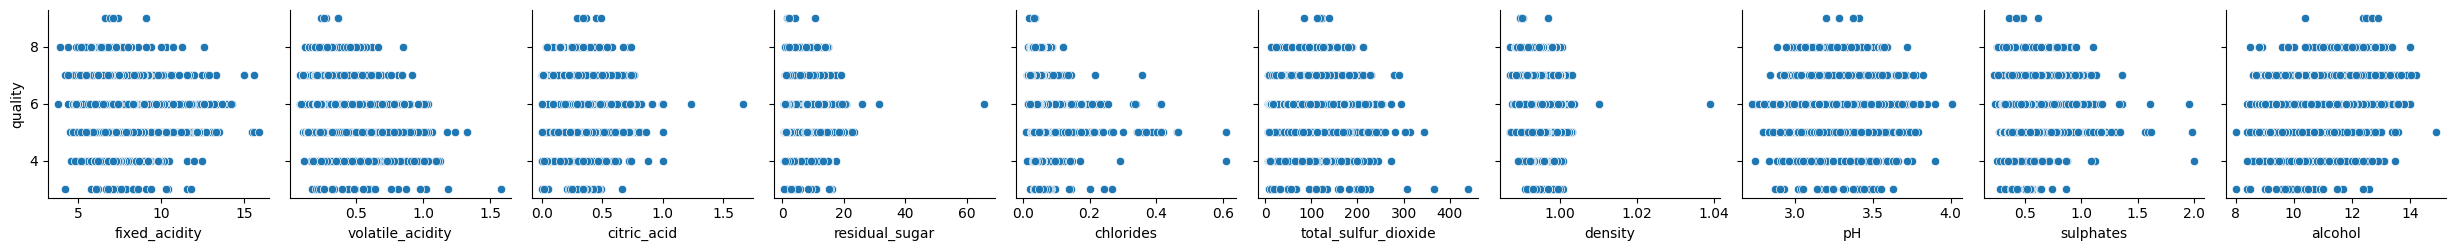

In [39]:
sns.pairplot(df_wine, y_vars='quality',x_vars=df_wine.columns[:-1])
plt.show()

As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [40]:
from sklearn.linear_model import LinearRegression

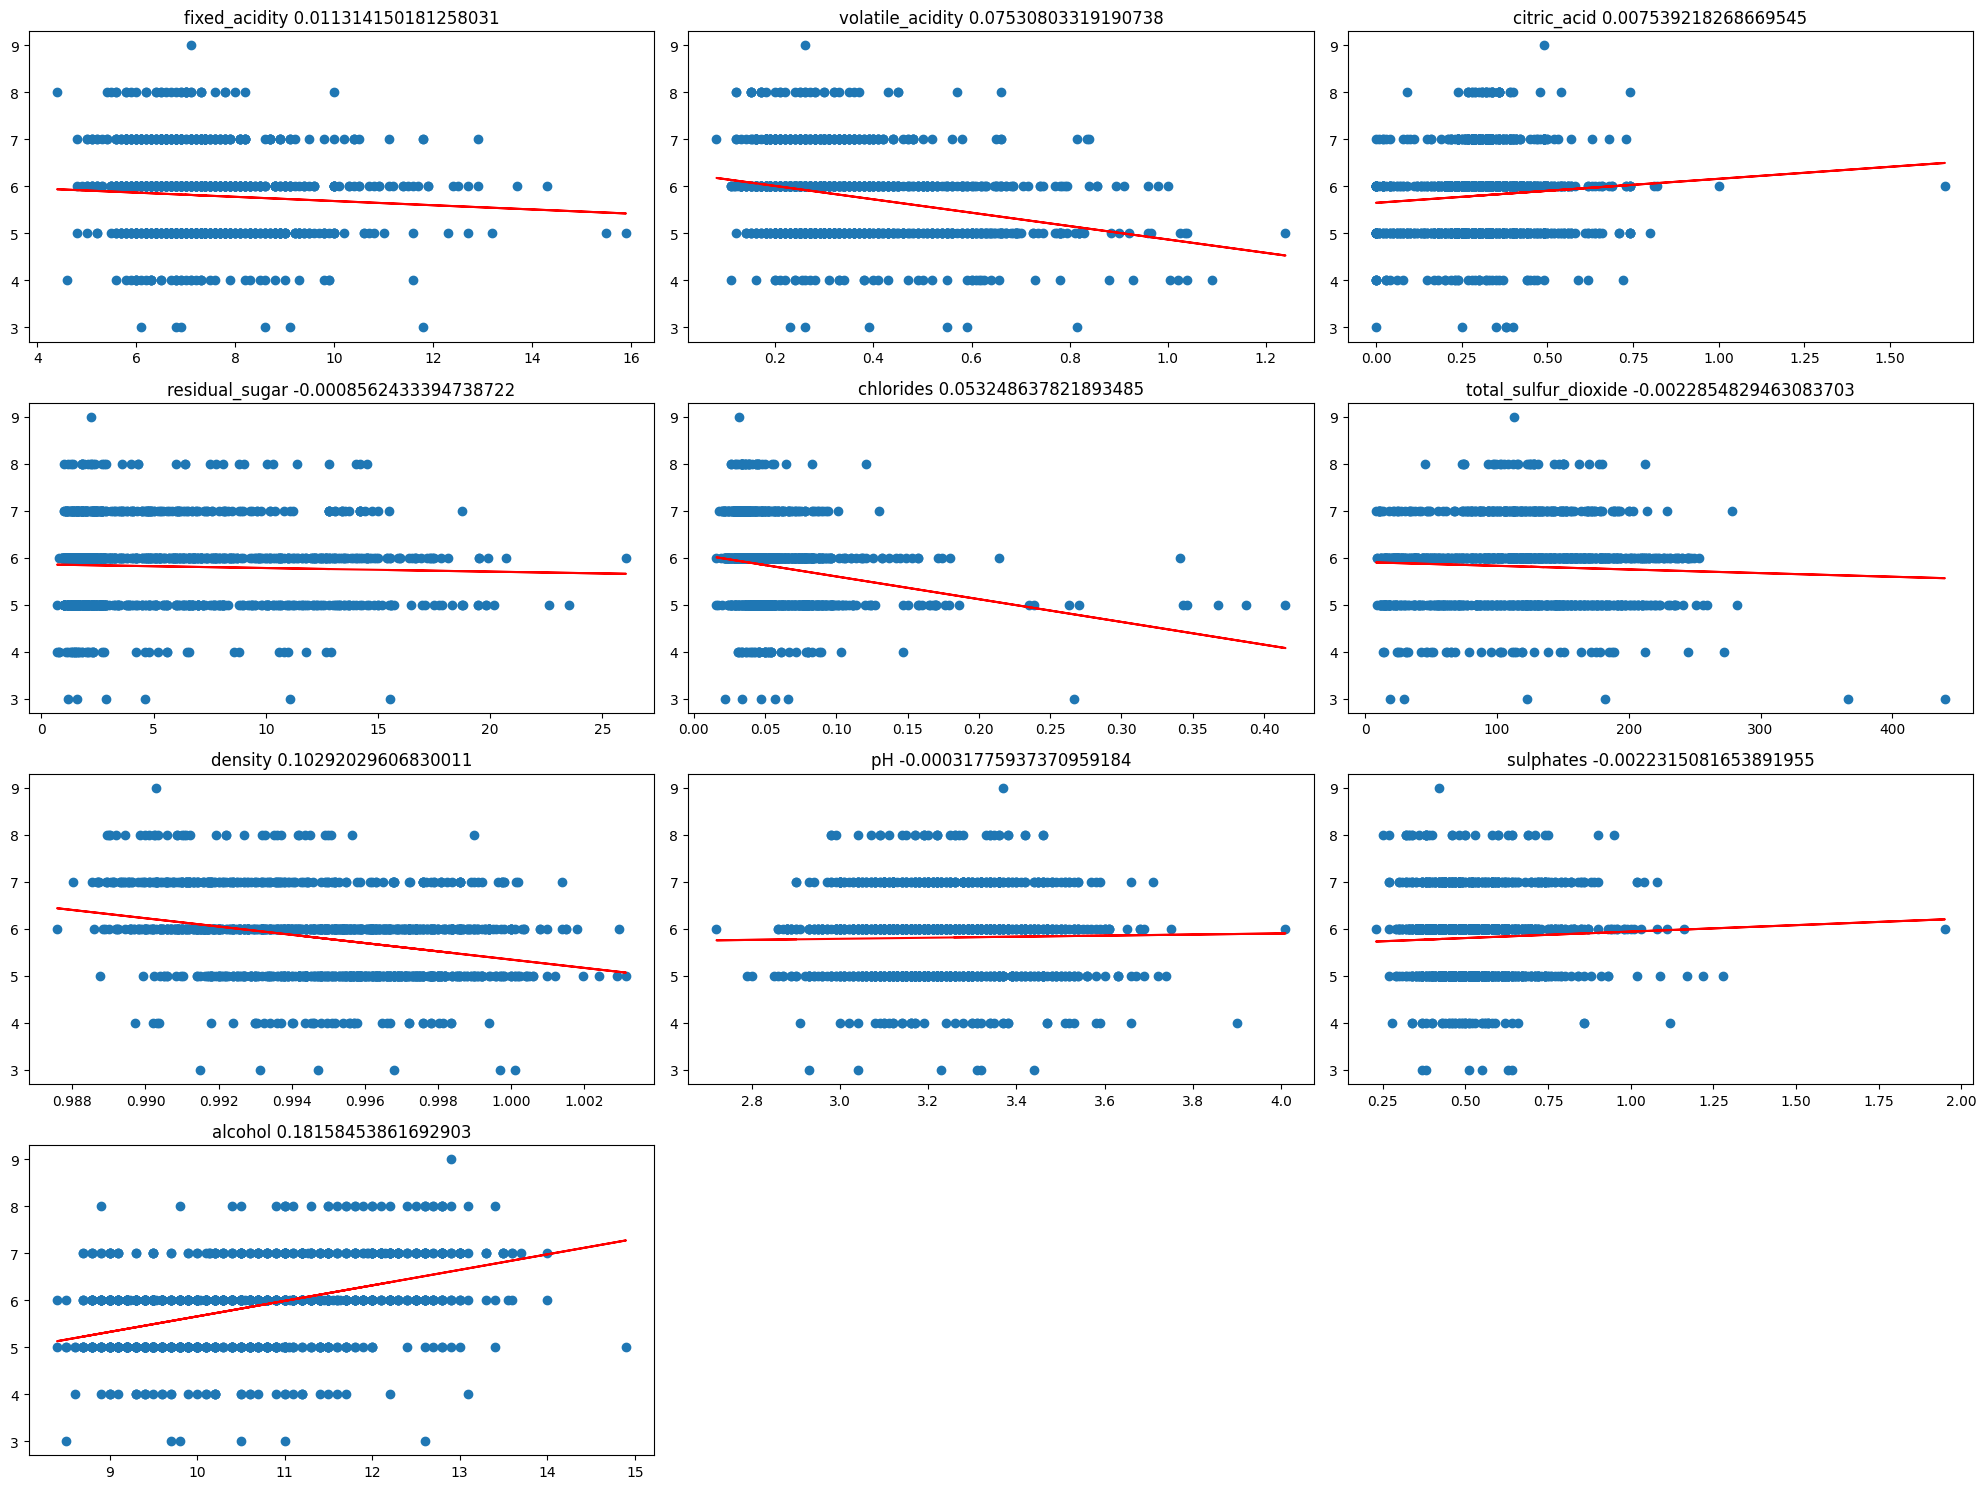

In [41]:
plt.figure(figsize=(20, 15))
y = df_wine['quality']
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    linear = LinearRegression()
    X = df_wine[[feature]] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    plt.scatter(X_test, y_test)
    plt.plot(X_test, y_pred, color='red')
    plt.title(f"{feature} {r2_score(y_test, y_pred)}")
plt.tight_layout()
plt.show()

The results shows, what we expected. That a simple linear regression model cannot be used to predict the quality of the wine that is a discrete variable.

The highest $R^2$ score is 0.18, for the feature alcohol, which is very low. The others are close to 0.

**Conclusion**: Can't use simple linear regression.

### Multilinear Regression

#### Multilinear Regression - Ridge criterion

The following block of code will make the preparations for a multilinear regression model using the Ridge criterion. The model will be trained and evaluated using the dataset. Firstly, the train-test division will be performed, then the model will be trained and evaluated following a cross validation factor of 5.

In [42]:
# Make the Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

# Create the Ridge Multilinear Regression model. We will
from sklearn.linear_model import RidgeCV
ridge_regressor = RidgeCV(cv=5)

# Fit the model
ridge_regressor.fit(X_train, y_train)

Train data shape:  (5197, 1) (5197,)
Test data shape:  (1300, 1) (1300,)


RidgeCV(cv=5)

The regression model has been successfully trained. Now, some metrics will be extracted from it:
As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [43]:
# Best lambda (alpha) selected by cross-validation
print(f"Best lambda selected by RidgeCV: {ridge_regressor.alpha_}")

Best lambda selected by RidgeCV: 10.0


In [44]:
# Predict on the testing sets
y_test_pred = ridge_regressor.predict(X_test)

============= METRICS FOR MODEL :  Multilinear Ridge  =================
Mean Squared Error  :  0.6008190111586731
Mean Absolute Error :  0.6128566329183097
R2 Score            :  0.2130482812903005


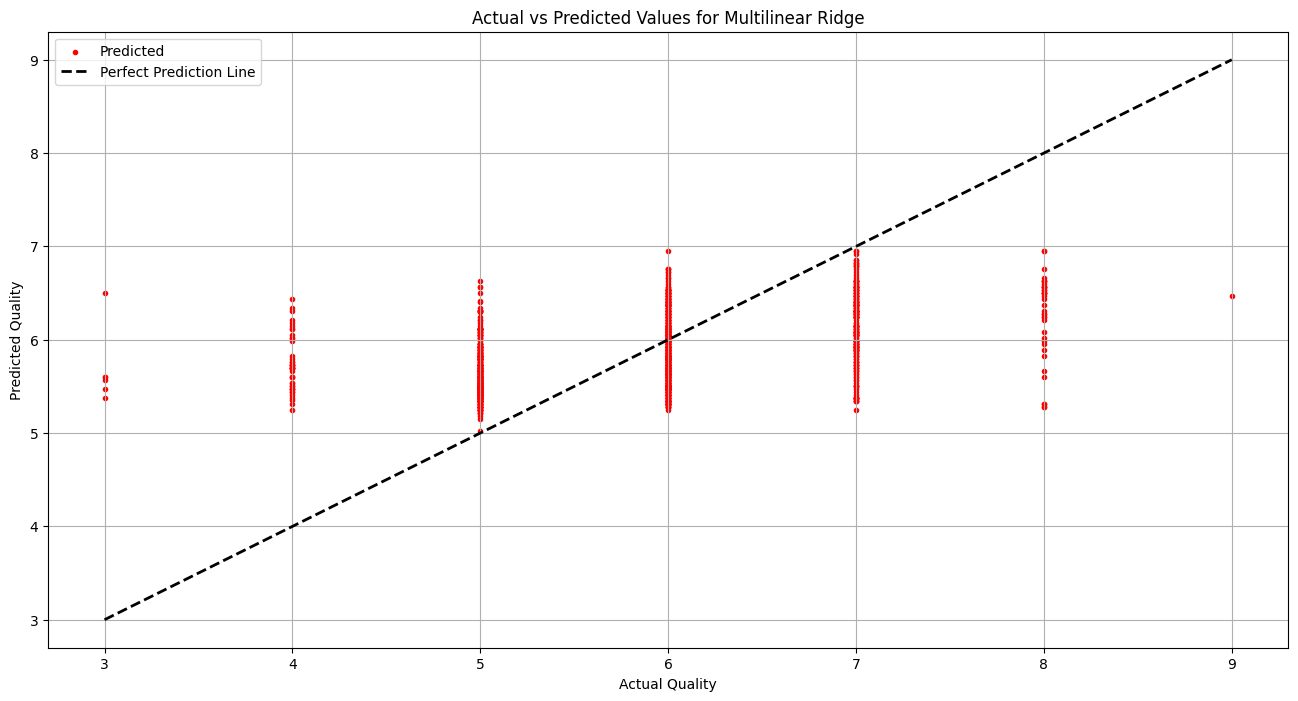

In [45]:
report_regression(y_test, y_test_pred, "Multilinear Ridge")

**Conclusion:** The model has not a good performance, the MSE is high and the R² score is low. This means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

#### Multilienar Regression - Lasso criterion

In [46]:
from sklearn.linear_model import LassoCV

For the Lasso Multilinear Regression model, cross validation will be done in a similar manner as with the Ridge model from before.

In [47]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (5197, 1) (5197,)
Test data shape:  (1300, 1) (1300,)


In [48]:
# Create and fit the model
warnings.filterwarnings("ignore")
lasso_regressor = LassoCV(cv=5)

lasso_regressor.fit(X_train, y_train)

LassoCV(cv=5)

In [49]:
print(f"Best lambda selected by LassoCV: {lasso_regressor.alpha_}")

Best lambda selected by LassoCV: 0.0004564618654576414


Finally, the model is tested on the test set and is evaluated by the following metrics:

- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- R² score

In [ ]:
y_test_pred = ridge_regressor.predict(X_test)

============= METRICS FOR MODEL :  Multilinear Lasso  =================
Mean Squared Error  :  0.6008190111586731
Mean Absolute Error :  0.6128566329183097
R2 Score            :  0.2130482812903005


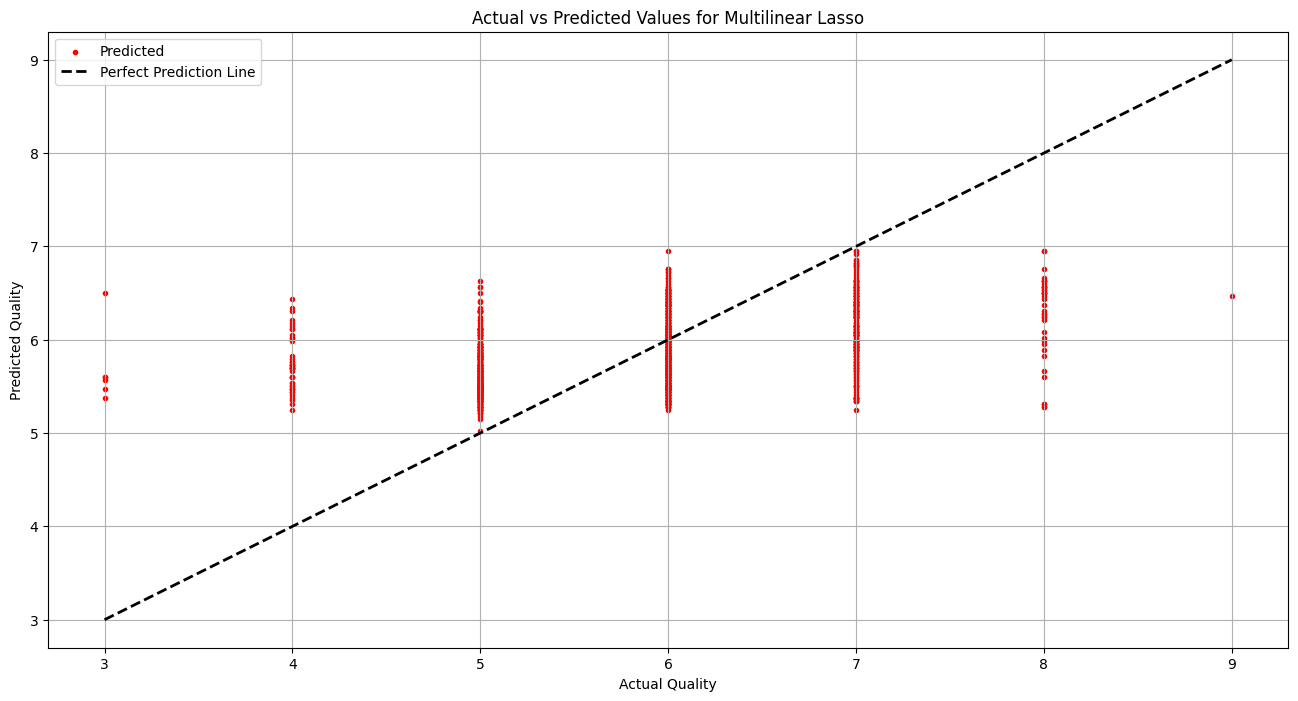

In [51]:
report_regression(y_test, y_test_pred, "Multilinear Lasso")

**Conclusion**: The model has an almost identical performance to the one with Ridge criterion. This means it also has not a very good performance, for the same reasons as mentioned above.

### Polynomial Regression

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (5197, 1) (5197,)
Test data shape:  (1300, 1) (1300,)


We will use `RandomizedSearchCV` in order to figure out the optimal degree of the polynomial for doing polynomial regression.

In [53]:

import numpy
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore")

param_dist={
    'polynomialfeatures__degree':[2,3,4,5,6,7,8]
}
pol_model=make_pipeline(PolynomialFeatures(),LinearRegression())
random_search = RandomizedSearchCV(estimator=pol_model, param_distributions=param_dist,
                                n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
best_pol_model = random_search.best_estimator_
# Print best model
print(f"Best Parameters from Random Search: {random_search.best_params_}")
print(f"Best Score from Random Search: {random_search.best_score_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters from Random Search: {'polynomialfeatures__degree': 7}
Best Score from Random Search: 0.21132276951274837


============= METRICS FOR MODEL :  Polynomial Regression  =================
Mean Squared Error  :  0.6885251749758303
Mean Absolute Error :  0.620678056360809
R2 Score            :  0.06772972853360415


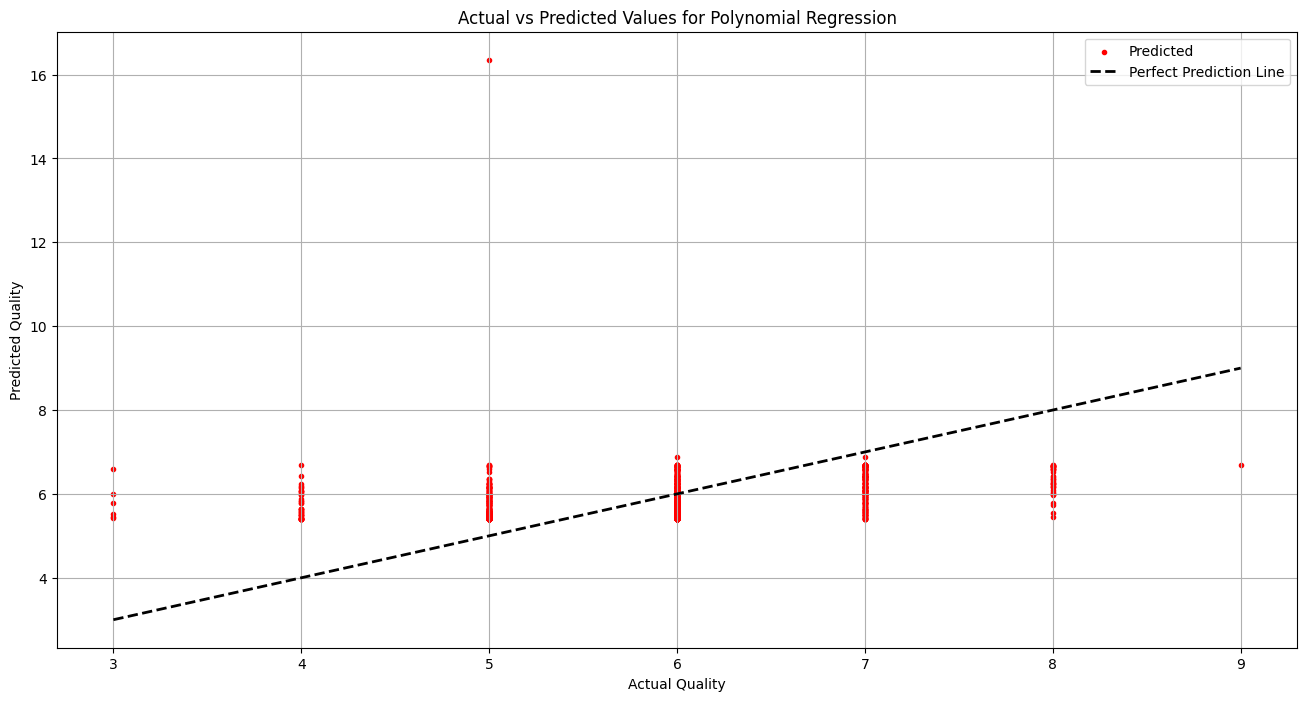

In [54]:
# Predict on the training and testing sets
y_test_pred_pol = best_pol_model.predict(X_test)


report_regression(y_test, y_test_pred_pol, "Polynomial Regression")

After training the model, we find the optimal degree for the polynomial regression to be 3.

The performance metrics would be the following:
* MSE = 0.60
* MAE = 0.61
* $R^2$ = 0.21

This is a similar performance to the previous 2 models, which is quite low.

### Decision Tree Regression

Decision trees are a Machine Learning technique characterized by its inductive nature: it consists of a directed tree where each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label.

The types of Decision trees vary by the types of features they handle. Many of them depend on the feature put as the root node, which can be found by many methods:

* **Randomly**.
* **By the entropy it generates.**
* **By using the Gini Index as KPI(only in binary decision trees)**.
* **By using the Knowledge Gain as KPI**.

First, a Regression Decision Tree model would be tried, but this problem has an already discrete target variable, so it is no use to try it. Instead, a Decision Tree model will be tried for classification models.


### Random Forest Regressor

The Random Forest Regressor model is based on decorrelated trees that reduce the variance of the model and reduce overfitting. This is a powerful tool as our dataset is higly imbalance.

In [56]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

We will use the parameter `stratify` in the `train_test_split` function to ensure that the distribution of the target variable is the same in the training and testing sets.

In [57]:
df_X = df_wine.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(df_X, df_wine['quality'], test_size=0.2, random_state=42, stratify=df_wine['quality'])

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (5197, 10) (5197,)
Test data shape:  (1300, 10) (1300,)


In [58]:
rf = RandomForestRegressor(random_state=42)

We have decided to use the `RandomizedSearchCV` to find the best hyperparameters as the performance is more or less equal to the `GridSearchCV` but it is 10 times faster (in this case). The hyperparameters that will be tuned are:
* n_estimators: the number of trees in the forest.
* max_depth: the maximum depth of the tree.
* min_samples_split: the minimum number of samples required to split an internal node.
* min_samples_leaf: the minimum number of samples required to be at a leaf node.

In [59]:
# Define the parameter distribution for Random Search
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

random_search.fit(X_train, y_train)

random_forest = random_search.best_estimator_
# Print best model 
print("Best Parameters from Random Search:", random_search.best_params_)
print("Best Score from Random Search:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from Random Search: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 138}
Best Score from Random Search: 0.45617625934512845


============= METRICS FOR MODEL :  Random Forest  =================
Mean Squared Error  :  0.3833461740699244
Mean Absolute Error :  0.4404590687986845
R2 Score            :  0.4978938333470212


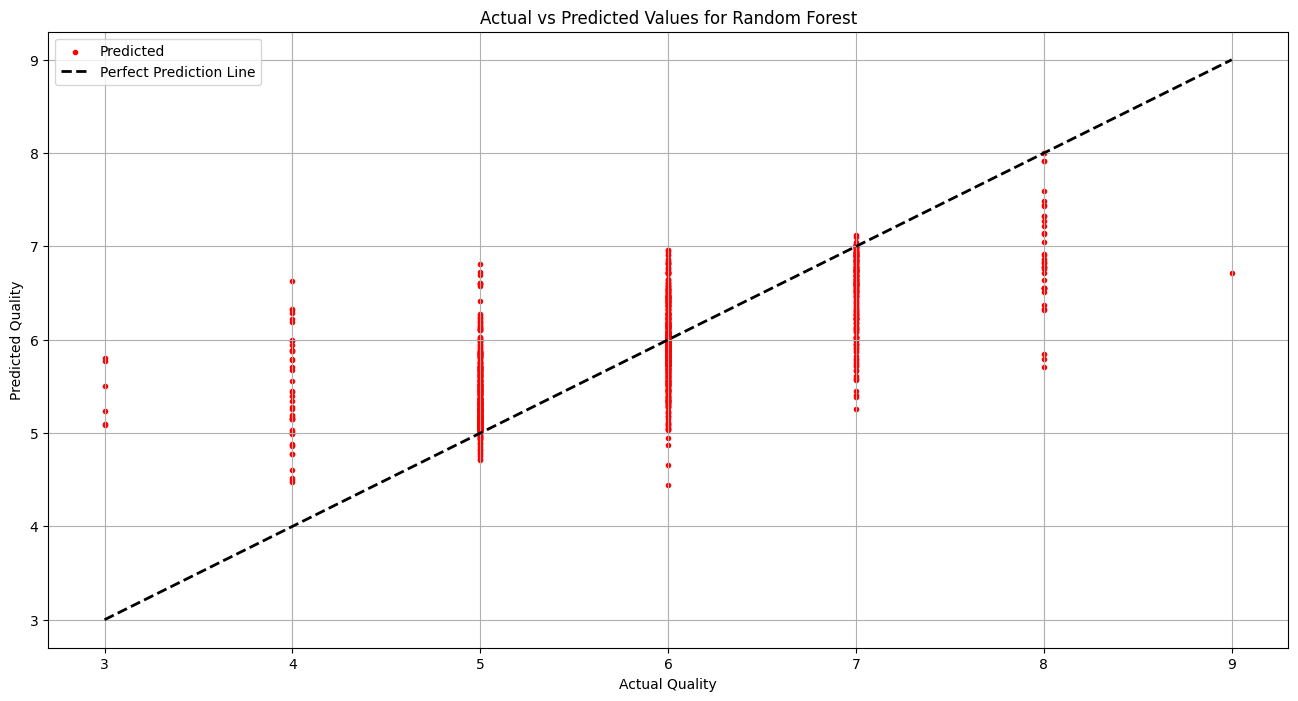

In [60]:
y_pred_random = random_forest.predict(X_test)
report_regression(y_test, y_pred_random, "Random Forest")

After training the model, the resulting best hyperparameters are:
* n_estimators: 138
* min_samples_split: 2
* min_samples_leaf: 1
* max_depth: 20

About the **performance metrics**, the best model achieves the following results:
* MSE = 0.387 which is lower than the variance of the target variable, so the mode's error is lower than the dispersion of the target variable.
* MAE = 0.441 means the error between the predicted and the true value is 0.441
* $R^2$ = 0.492 means that the model explains almost half of the variance of the `quality` variable.


Most of the `quality` values are between 7 and 5, so the model is better at predicting these values. 

From the plot below, we can see the predictions for each instance in the test set. The blue line represents the true value and the red line represents the predicted value. The closer the red line is to the blue line, the better the prediction is.

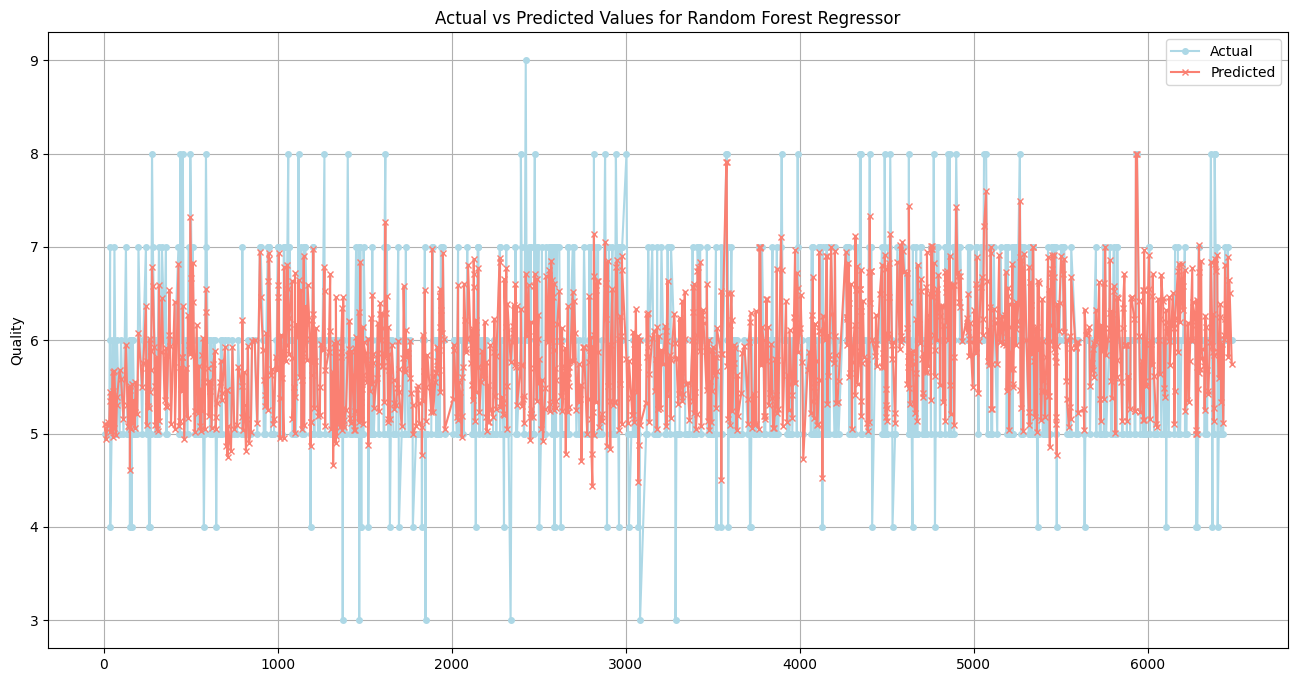

In [61]:
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_random}, index=X_test.index)
plot_df.sort_index(inplace=True)

# Plotting the actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', color='lightblue', marker='o', markersize=4)
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', color='salmon', marker='x', markersize=4)

plt.title('Actual vs Predicted Values for Random Forest Regressor')
plt.ylabel('Quality')
plt.legend()
plt.grid()

Now, let's check the importance of the features in the model to test if reducing the dimensionality of the dataset could improve the model.
This are the importance of the features in the random forest regressor model:

In [62]:
print ('Feature Relevances')
print(pd.DataFrame({'Attributes': X_train.columns,
            'Feature importance':random_search.best_estimator_.feature_importances_}).sort_values('Feature importance', ascending=False))

Feature Relevances
             Attributes  Feature importance
9               alcohol            0.255896
1      volatile_acidity            0.144409
5  total_sulfur_dioxide            0.088601
3        residual_sugar            0.083298
8             sulphates            0.080284
7                    pH            0.077638
4             chlorides            0.072208
2           citric_acid            0.067276
0         fixed_acidity            0.065443
6               density            0.064945


In [63]:
#Uncomment for retraining with a subset
# new_df = df_wine[['alcohol', 'volatile_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'sulphates', 'pH']]
# X_train, X_test, y_train, y_test = train_test_split(new_df, df_wine['quality'], test_size=0.2, random_state=42, stratify=df_wine['quality'])

# rf = RandomForestRegressor(random_state=42)
# param_dist = {
#     'n_estimators': randint(50, 300),
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': randint(2, 11),
#     'min_samples_leaf': randint(1, 5)
# }
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                                 n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

# random_search.fit(X_train, y_train)
# y_pred_random_subset = random_search.predict(X_test)

# # Print statics
# print("Best Parameters from Random Search:", random_search.best_params_)
# print("Best Score from Random Search:", random_search.best_score_)
# print("----Test set----")
# print(f"MSE(subset) = {mean_squared_error(y_test, y_pred_random_subset):.3f} vs MSE(full) = {mean_squared_error(y_test, y_pred_random):.3f}")
# print(f"R2(subset) = {r2_score(y_test, y_pred_random_subset):.3f} vs R2(full) = {r2_score(y_test, y_pred_random):.3f}")
# print(f"MAE(subset) = {mean_absolute_error(y_test, y_pred_random_subset):.3f} vs MAE(full) = {mean_absolute_error(y_test, y_pred_random):.3f}")

The most important features is the `alcohol` whereas the least important is the `citric_acid`. Although training the model again with a subset of the features improves the time, it does not improve the performance of the model. Taking int account that the error should decrease and the $R^2$ should increase.

**Conclusion for Random Forest Regressor**: This might be a good model if we want to focus on the most common values of the quality (5, 6 and 7). However, the model is not able to predict the extreme values of the quality (3 and 9).


### Generative Additive Models (GAMs)

GAMs are derivations of a standard linear models which apply non-linear functions to predictors, all whilst mainting the additive structure of the model. They can be taken as an abstraction for a linear regression model.

Their formula can be written as: 

$y_i$ = $\beta_0$ + $\sum_{j=1}^p f_j(x_{ij}) + \epsilon_i $

As explained before, regression models are not suitable for this problem due to the discrete nature of the target variable. Nevertheless, let's try to fit a GAM model to the dataset.


In [ ]:
from pygam import LinearGAM, s, l

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)
# Create the Generalized Additive Model
gam_regressor = LinearGAM(  l(0) +
                            s(1) +
                            l(2) +
                            s(3) +
                            l(4) +
                            s(5) +
                            l(6) +
                            s(7) +
                            l(8) +
                            s(9)
                        ).fit(X_train, y_train)

It's now time to make predictions on the test set and evaluate the model using the following metrics:

- Mean Squared Error (MSE)
- R² score

In [ ]:
# Predict on the train and test set 
y_train_pred = gam_regressor.predict(X_train)
y_test_pred = gam_regressor.predict(X_test)

# Compare the results by using MSE and R2
train_mse_gam = mean_squared_error(y_train, y_train_pred)
print(f"Train MSE: {train_mse_gam}")

test_mse_gam = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse_gam}")

train_r2_gam = r2_score(y_train, y_train_pred)
print(f"Train R2: {train_r2_gam}")

test_r2_gam = r2_score(y_test, y_test_pred)
print(f"Test R2: {test_r2_gam}")

The performance metrics do not look good at all. A graphical description of the performance is shown in the plots below:

In [ ]:
# Function plot
plt.figure()
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

titles = ['Fixed Acidity', 'Volatile Acidity', 'Citric Acid', 'Residual Sugar', 'Chlorides', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol']
for i, ax in enumerate(axs):
    XX = gam_regressor.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_regressor.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_regressor.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

After the plots, a summary of the model's performance is shown.

In [ ]:
gam_regressor.summary()

The P-Value is way too low, which means that the predictions of the model are very unreliable.

**Conclusion:** As expected, both MSE and R² score report very low performance, and so do the plots and the summary, which means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

### Final decision

Here we mention the best model.

=========== MODELS COMPARISON ===========


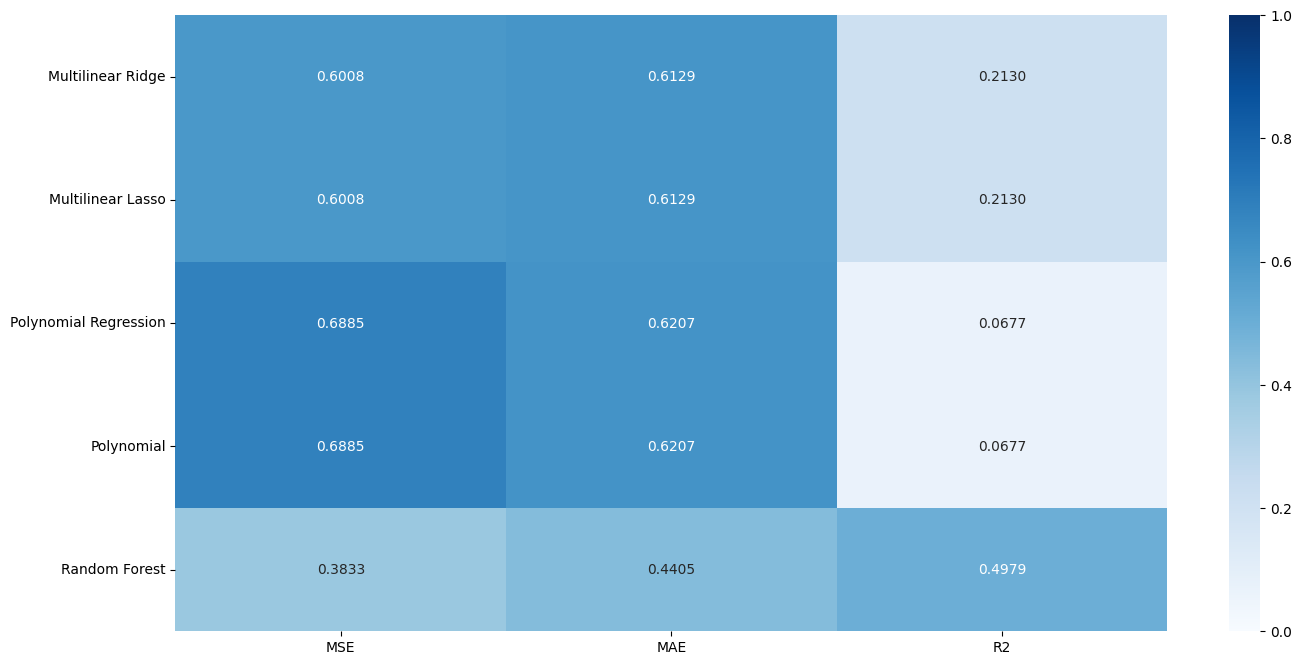

In [68]:
print('=========== MODELS COMPARISON ===========')
plt.figure(figsize=[16,8])
sns.heatmap(regression_results, annot=True, cmap='Blues', fmt='.4f', vmin=0, vmax=1)
plt.show()

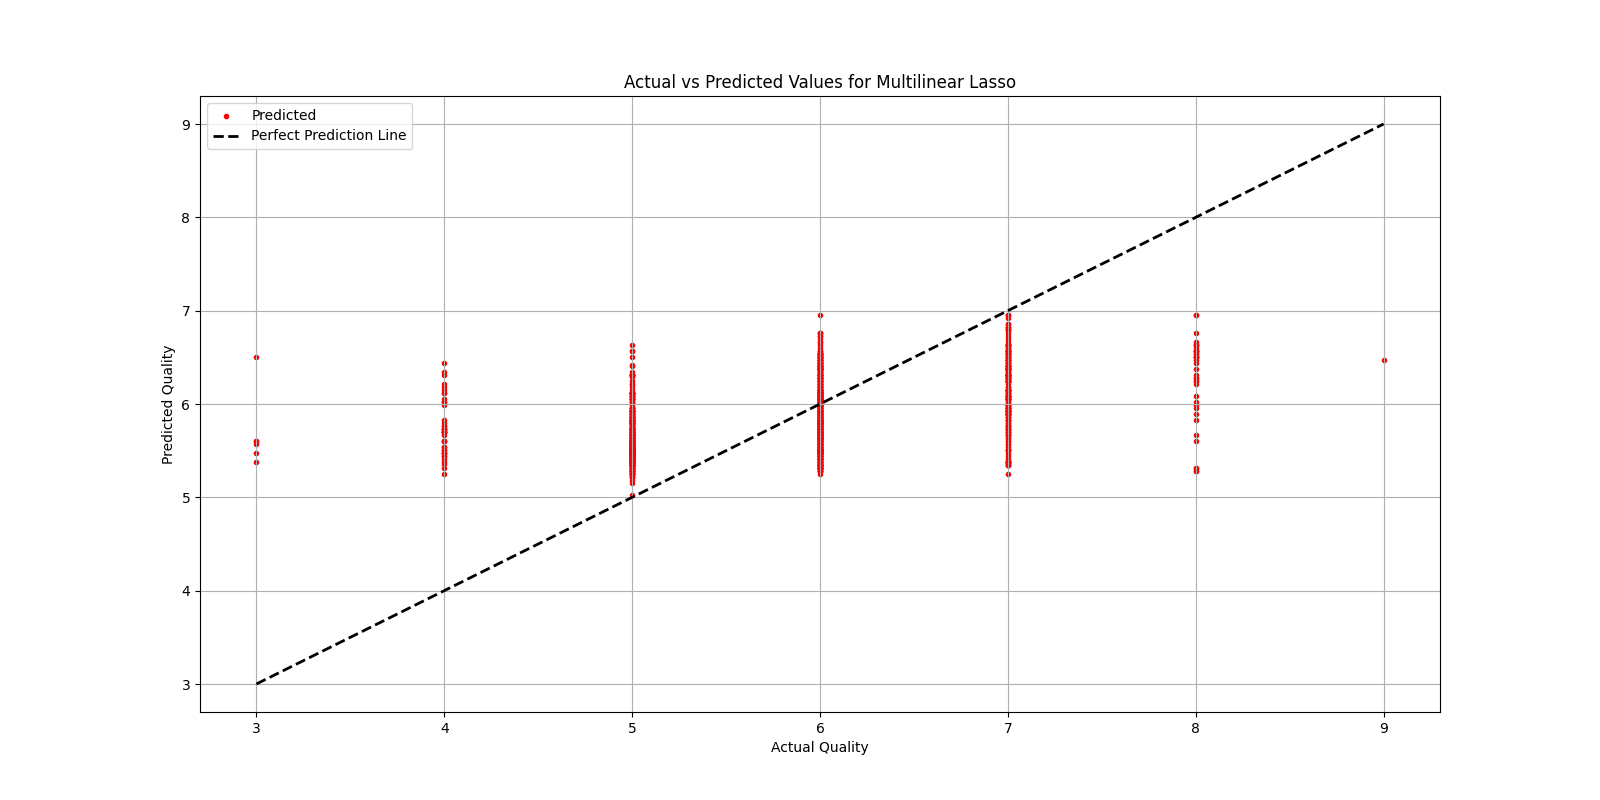

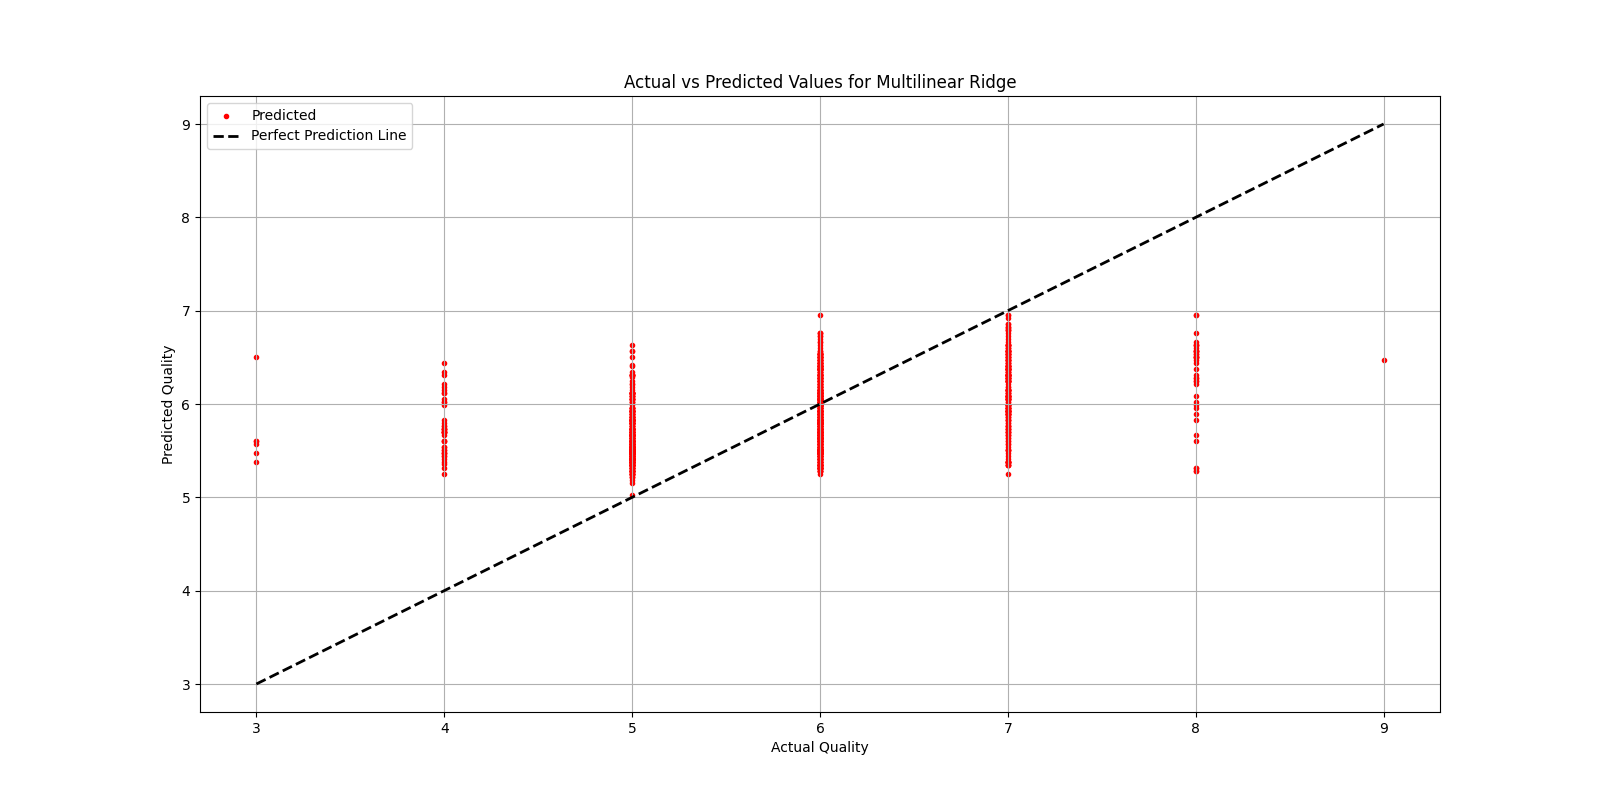

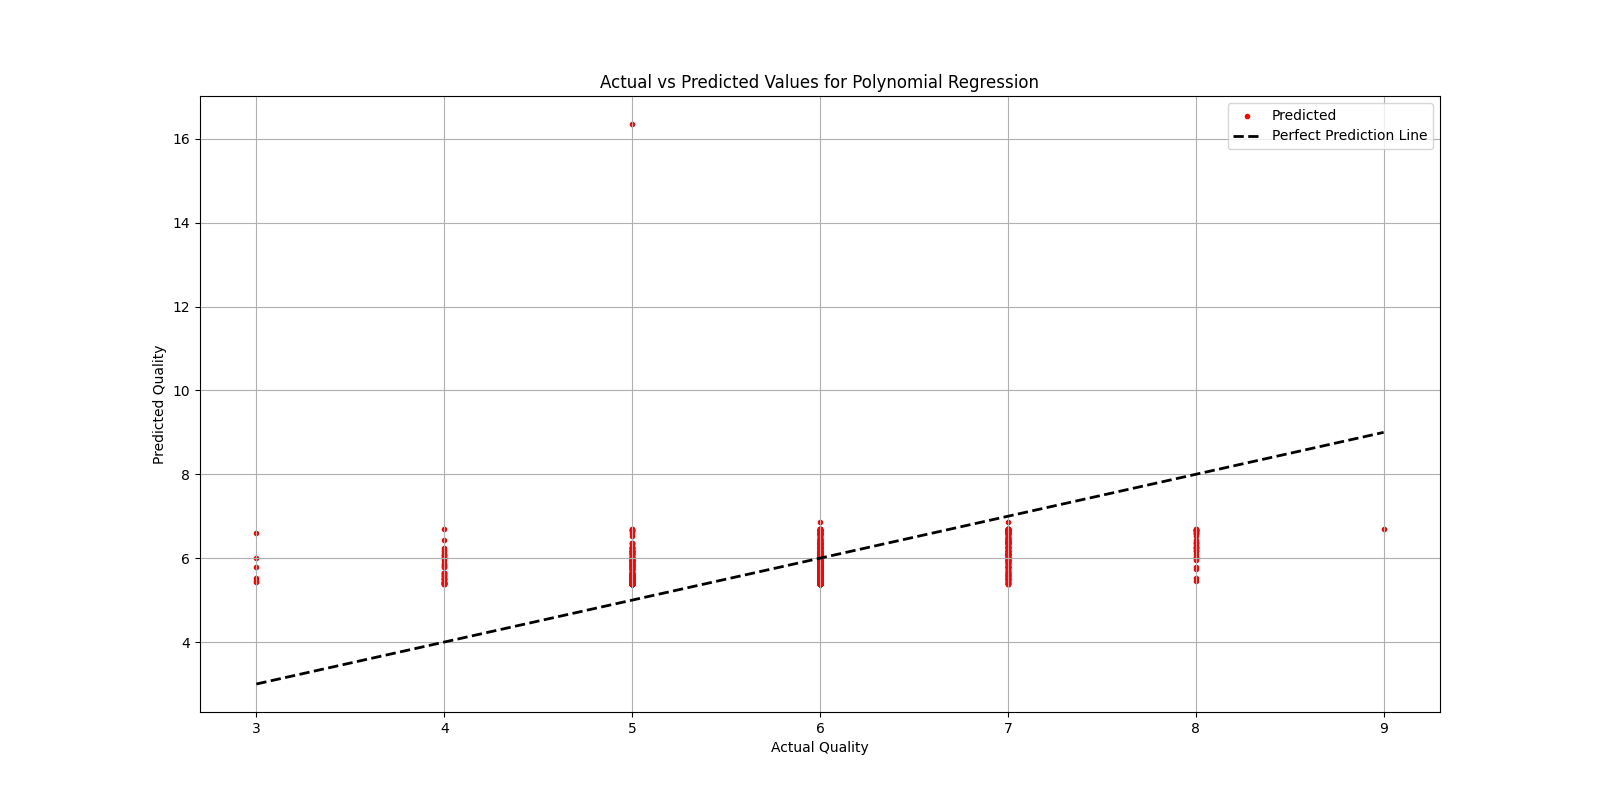

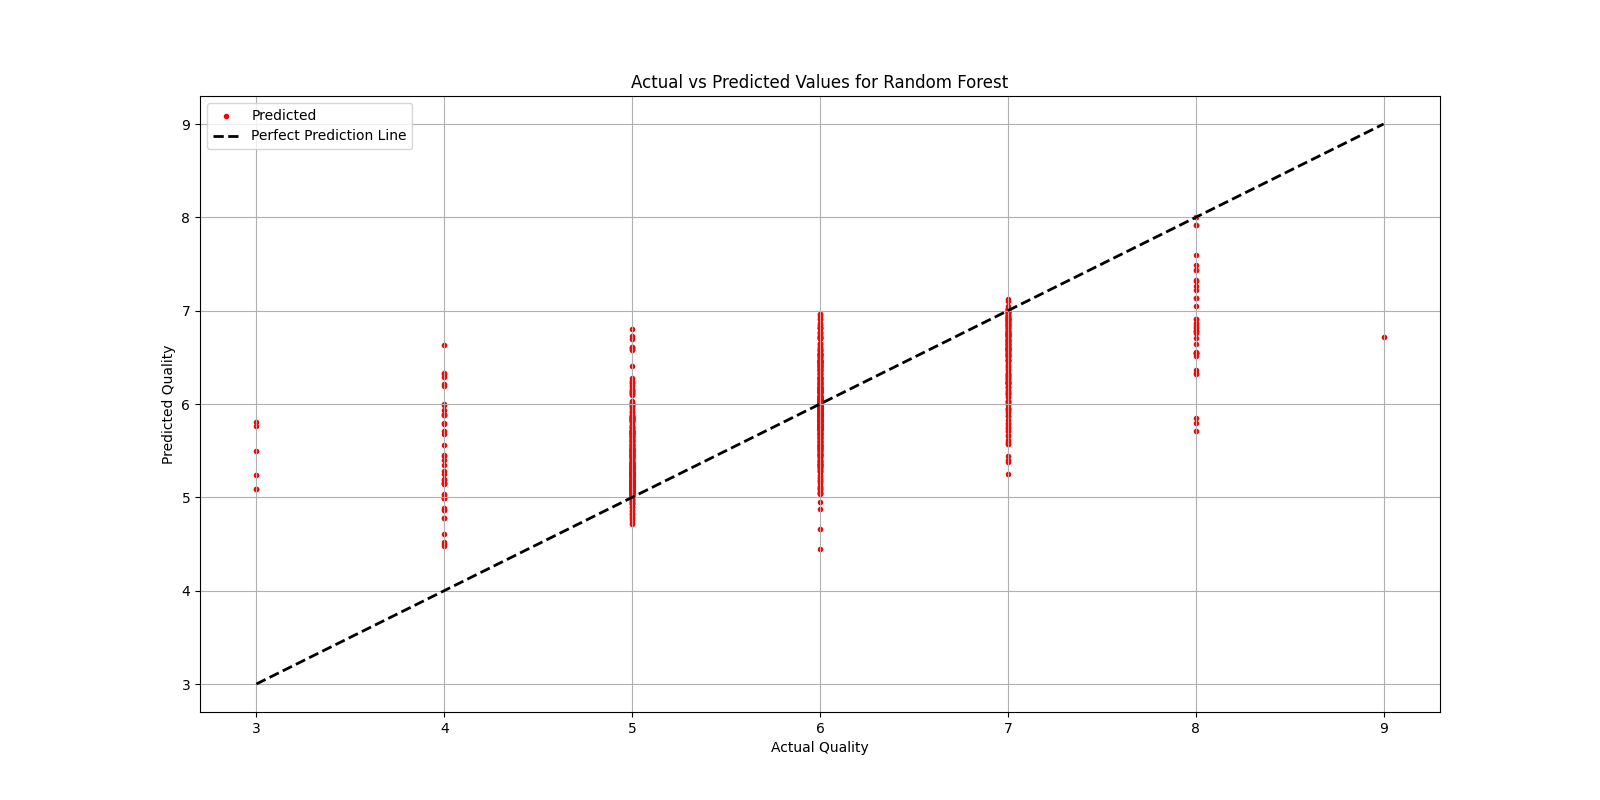

In [71]:
from IPython.display import Image
import os

for file in os.listdir("img_regression"):
    display(Image(filename="img_regression/"+file))
